In [1]:
from google.colab import drive
import os
import zipfile
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import shutil
# Libraries for do visualization
import matplotlib.image as mpimg
import datetime
import time
import os

# Data handling and numerical operations
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import load_img

# TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import (
    Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten,
    GlobalAveragePooling2D, Rescaling, Normalization
)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, TensorBoard, EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import clear_session

# Scikit-learn for model evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
class DataPreparation:
    def __init__(self, zip_path):
      drive.mount('/content/Drive')
      self.zip_path = zip_path
      self.destination_folder="/content/Dataset/"

    def clear_destination_folder(self,original=True):
        for item in os.listdir(self.destination_folder):
            item_path = os.path.join(self.destination_folder, item)
            if original:
              if os.path.isdir(item_path) and item in ['train', 'val', 'test']:
                continue
              shutil.rmtree(item_path, ignore_errors=True)
            else:
              if os.path.isdir(item_path) and item not in ['train', 'val', 'test']:
                continue
              shutil.rmtree(item_path, ignore_errors=True)

    def extract_zip_file(self):
      with zipfile.ZipFile(self.zip_path, 'r') as zf:
        for member in tqdm(zf.infolist(), desc='Extracting'):
          try:
            zf.extract(member, self.destination_folder)
          except zipfile.error as e:
              print(f"Error extracting {member}: {e}")

    def print_class_counts(self):
      try:
        class_names = sorted(os.listdir(self.destination_folder))
        for class_name in class_names:
          class_path = os.path.join(self.destination_folder, class_name)
          if os.path.isdir(class_path):
            contents = os.listdir(class_path)
            print(f"{class_name}: {len(contents)}")
          else:
            print(f"{class_name} is not a directory.")
      except FileNotFoundError:
        print(f"The path '{self.destination_folder}' does not exist.")

    def split_data(self, test_size=0.2, val_size=0.25):
        self.clear_destination_folder(original=False)
        class_names = [d for d in os.listdir(self.destination_folder) if os.path.isdir(os.path.join(self.destination_folder, d))]

        for split in ['train', 'val', 'test']:
            os.makedirs(os.path.join(self.destination_folder, split), exist_ok=True)
            for class_name in class_names:
                os.makedirs(os.path.join(self.destination_folder, split, class_name), exist_ok=True)

        for class_name in class_names:
            class_path = os.path.join(self.destination_folder, class_name)
            files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

            if not files:
                continue

            # Split files into training+validation and test sets
            train_val_files, test_files = train_test_split(files, test_size=test_size, random_state=42)

            # split training+validation files into training and validation sets
            train_files, val_files = train_test_split(train_val_files, test_size=val_size / (1 - test_size), random_state=42)

            # Move files to their new respective directories
            for file in train_files:
                shutil.move(os.path.join(class_path, file), os.path.join(self.destination_folder, 'train', class_name, file))
            for file in val_files:
                shutil.move(os.path.join(class_path, file), os.path.join(self.destination_folder, 'val', class_name, file))
            for file in test_files:
                shutil.move(os.path.join(class_path, file), os.path.join(self.destination_folder, 'test', class_name, file))

            print(f"Processed {class_name}: Train files: {len(train_files)}, Validation files: {len(val_files)}, Test files: {len(test_files)}")
        self.clear_destination_folder()


In [3]:
destination_folder="/content/Dataset/"
train_dir=os.path.join(destination_folder, 'train')
val_dir=os.path.join(destination_folder, 'val')
test_dir=os.path.join(destination_folder, 'test')

In [4]:
zip_path = '/content/Drive/MyDrive/fruit_data.zip'
data_preprocessor = DataPreparation(zip_path)
data_preprocessor.extract_zip_file()
data_preprocessor.print_class_counts()
data_preprocessor.split_data(test_size=0.15,val_size=0.2)

Mounted at /content/Drive


Extracting: 100%|██████████| 1655/1655 [00:00<00:00, 1895.63it/s]

fresh_peaches_done: 250
fresh_pomegranates_done: 311
fresh_strawberries_done: 250
rotten_peaches_done: 343
rotten_pomegranates_done: 250
rotten_strawberries_done: 251
Processed fresh_strawberries_done: Train files: 162, Validation files: 50, Test files: 38
Processed rotten_pomegranates_done: Train files: 162, Validation files: 50, Test files: 38
Processed fresh_pomegranates_done: Train files: 201, Validation files: 63, Test files: 47
Processed rotten_peaches_done: Train files: 222, Validation files: 69, Test files: 52
Processed rotten_strawberries_done: Train files: 162, Validation files: 51, Test files: 38
Processed fresh_peaches_done: Train files: 162, Validation files: 50, Test files: 38


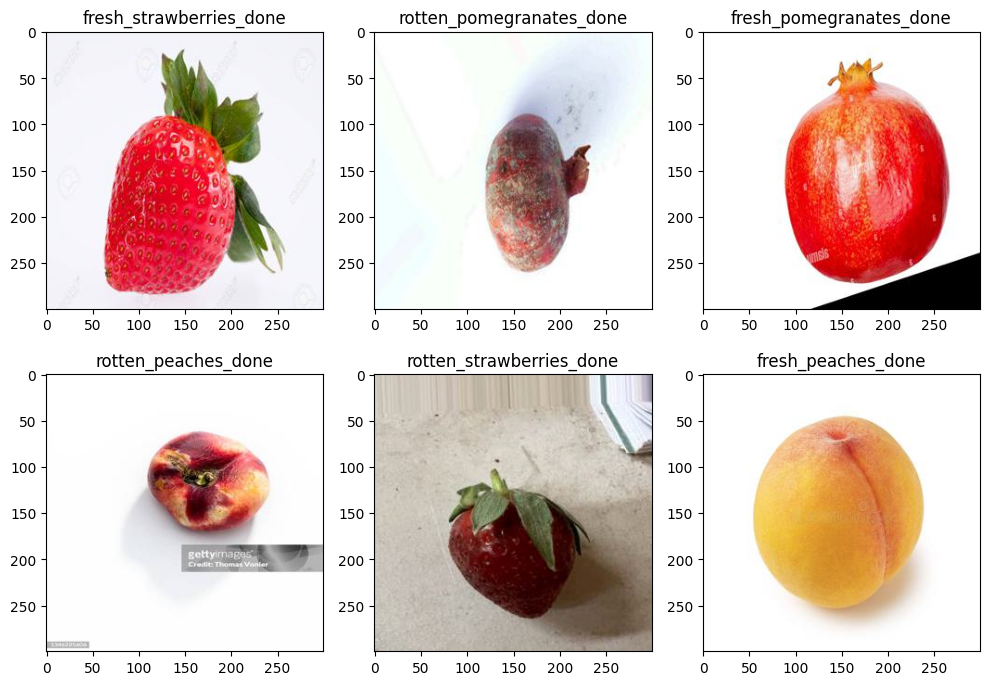

In [5]:
train_dir = '/content/Dataset/train/'

fig, axs = plt.subplots(2, 3, figsize=(10, 7))
axs = axs.ravel()

for i, class_dir in enumerate(os.listdir(train_dir)):
    class_dir_path = os.path.join(train_dir, class_dir)

    if os.path.isdir(class_dir_path):
        files = os.listdir(class_dir_path)

        images = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
        first_image_path = os.path.join(class_dir_path, images[0])

        img = load_img(first_image_path)
        axs[i].imshow(img)
        axs[i].set_title(class_dir)
        if i == 5:
          break

plt.tight_layout()
plt.show()


In [6]:
def generators(train_dir,val_dir,test_dir):
      train_datagen = ImageDataGenerator(rescale=1./255,
                                         rotation_range=30,
                                         brightness_range=[0.8,1.2],
                                         shear_range=0.1,
                                         zoom_range=0.1,
                                         fill_mode='nearest',
                                         horizontal_flip=True,
                                         vertical_flip=True)

      train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                          target_size=(300, 300),
                                                          color_mode='rgb',
                                                          class_mode='sparse',
                                                          batch_size=32,
                                                          shuffle=True,
                                                          seed=127,
                                                          subset='training',
                                                          interpolation='nearest',
                                                          keep_aspect_ratio=False)

      validation_datagen = ImageDataGenerator(rescale=1./255)
      validation_generator = validation_datagen.flow_from_directory(directory=val_dir,
                                                                batch_size=32,
                                                                class_mode = 'sparse',
                                                                target_size=(300, 300),
                                                                shuffle=False)
      test_datagen = ImageDataGenerator(rescale=1./255)
      test_generator = validation_datagen.flow_from_directory(directory=test_dir,
                                                                batch_size=32,
                                                                class_mode = 'sparse',
                                                                target_size=(300, 300),
                                                                shuffle=False)
      return train_generator, validation_generator,test_generator
train_generator, validation_generator,test_generator=generators(train_dir,val_dir,test_dir)

Found 1071 images belonging to 6 classes.
Found 333 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


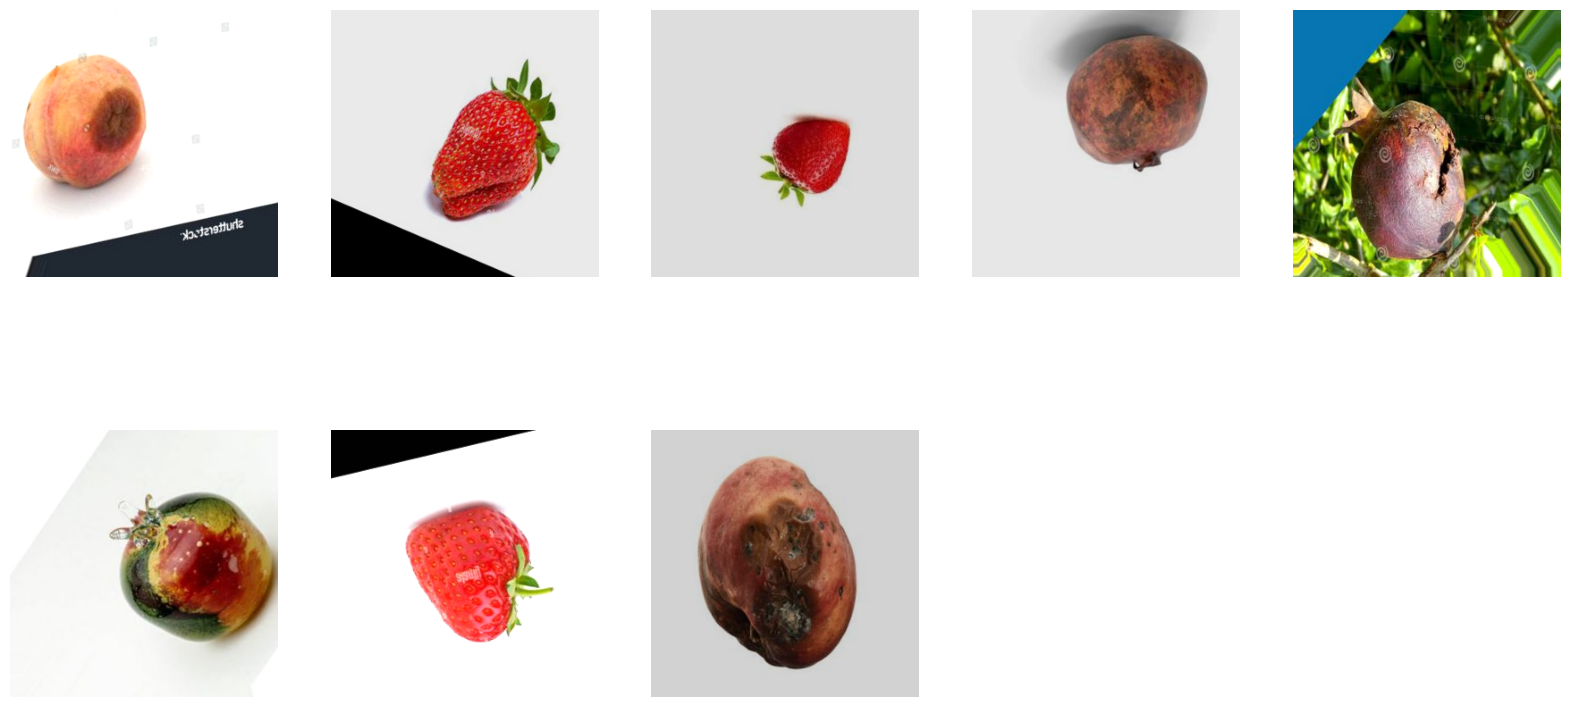

In [7]:
# Get a batch of images
x_batch, y_batch = next(train_generator)

# Plot the images
plt.figure(figsize=(20, 10))
for i in range(8):  # Display the first 10 images from the batch
    plt.subplot(2, 5, i+1)
    plt.imshow(x_batch[i])
    plt.axis('off')  # Optional: Remove axis
plt.show()

# ResNet-50 Model


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# make the top layers of the base model trainable
base_model.trainable = True
for layer in base_model.layers[:-5]:  # rreeze all layers except the last 5
    layer.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam(learning_rate=0.00006)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k=2)])


start_time = time.time()
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20
)

end_time = time.time()
speed = (end_time - start_time) / 20 #num epochs

print("Speed: " + str(speed) + " seconds per epoch")

Epoch 1/20
34/34 [==============================] - 27s 694ms/step - loss: 1.9772 - accuracy: 0.1830 - sparse_top_k_categorical_accuracy: 0.3548 - val_loss: 1.7943 - val_accuracy: 0.2072 - val_sparse_top_k_categorical_accuracy: 0.3574
Epoch 2/20
34/34 [==============================] - 23s 676ms/step - loss: 1.8272 - accuracy: 0.2082 - sparse_top_k_categorical_accuracy: 0.4024 - val_loss: 1.8186 - val_accuracy: 0.2222 - val_sparse_top_k_categorical_accuracy: 0.3814
Epoch 3/20
34/34 [==============================] - 23s 675ms/step - loss: 1.7640 - accuracy: 0.2316 - sparse_top_k_categorical_accuracy: 0.4416 - val_loss: 1.7701 - val_accuracy: 0.2252 - val_sparse_top_k_categorical_accuracy: 0.3934
Epoch 4/20
34/34 [==============================] - 23s 675ms/step - loss: 1.6986 - accuracy: 0.2801 - sparse_top_k_categorical_accuracy: 0.5014 - val_loss: 1.6597 - val_accuracy: 0.3483 - val_sparse_top_k_categorical_accuracy: 0.5766
Epoch 5/20
34/34 [==============================] - 23s 685m

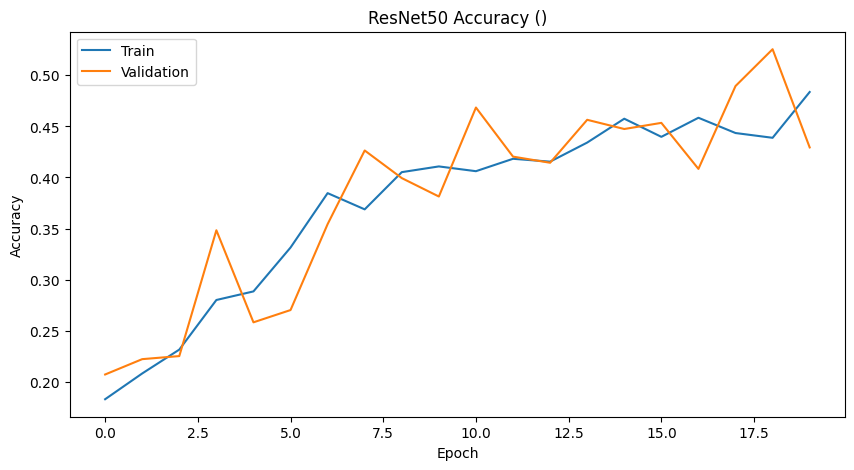

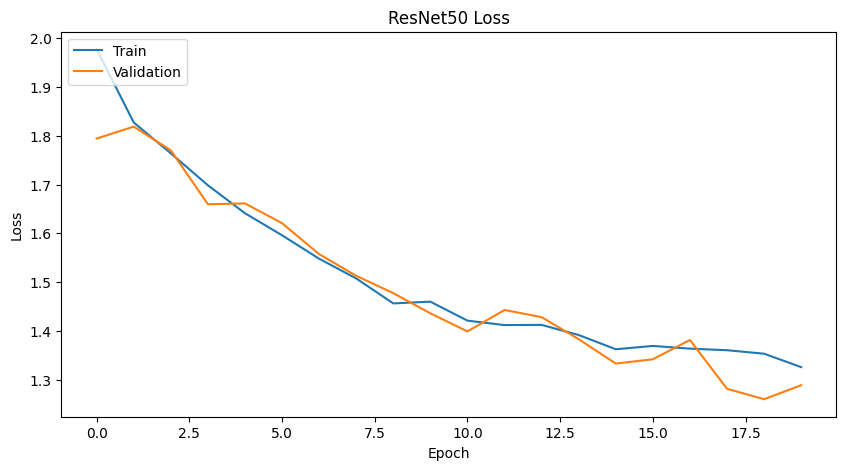

In [ ]:
# Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet50 Accuracy ()')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet50 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# EfficientNet Model


In [8]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import time

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True
for layer in base_model.layers[:-5]:  # freeze all layers except the last 5
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k=2)])


start_time = time.time()

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20
)


end_time = time.time()
speed = (end_time - start_time) / 20

print("Speed: " + str(speed) + " seconds per epoch")


16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/20
34/34 [==============================] - 47s 997ms/step - loss: 1.8274 - accuracy: 0.1905 - sparse_top_k_categorical_accuracy: 0.3455 - val_loss: 1.7996 - val_accuracy: 0.1502 - val_sparse_top_k_categorical_accuracy: 0.3393
Epoch 2/20
34/34 [==============================] - 30s 880ms/step - loss: 1.8168 - accuracy: 0.1737 - sparse_top_k_categorical_accuracy: 0.3697 - val_loss: 1.7925 - val_accuracy: 0.1892 - val_sparse_top_k_categorical_accuracy: 0.3423
Epoch 3/20
34/34 [==============================] - 29s 850ms/step - loss: 1.8160 - accuracy: 0.1979 - sparse_top_k_categorical_accuracy: 0.3651 - val_loss: 1.7945 - val_accuracy: 0.1892 - val_sparse_top_k_categorical_accuracy: 0.3393
Epoch 4/20
34/34 [==============================] - 30s 890ms/step - loss: 1.8020 - accuracy: 0.2035 - sparse_top_k_categorical_accuracy: 0.4006 - val_loss: 1.7938 - val_accuracy: 0.1892 - val_sparse_top_k_categorical_accuracy: 0.

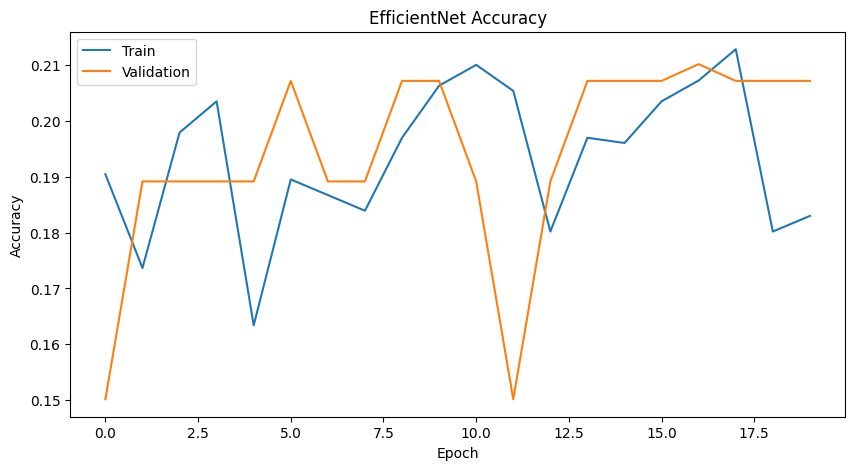

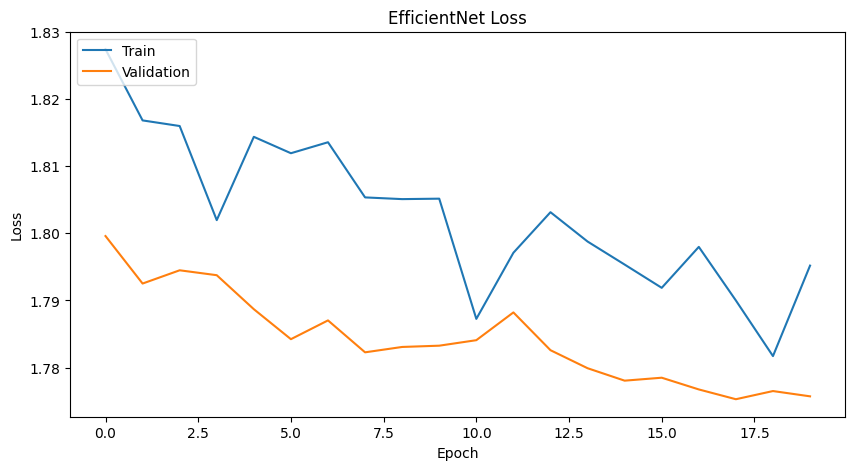

In [10]:
# Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('EfficientNet Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('EfficientNet Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# MobileNetV2 Model


In [12]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)

model1 = Model(inputs=base_model.input, outputs=predictions)

model1.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k=2)])
start_time = time.time()
history = model1.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)
end_time = time.time()
speed = (end_time - start_time) / 10 #num epochs

print("Speed: " + str(speed) + " seconds per epoch")


Epoch 1/10
34/34 [==============================] - 38s 1s/step - loss: 0.7765 - accuracy: 0.7386 - sparse_top_k_categorical_accuracy: 0.8852 - val_loss: 0.3937 - val_accuracy: 0.8649 - val_sparse_top_k_categorical_accuracy: 0.9610
Epoch 2/10
34/34 [==============================] - 28s 832ms/step - loss: 0.2799 - accuracy: 0.8898 - sparse_top_k_categorical_accuracy: 0.9813 - val_loss: 0.2690 - val_accuracy: 0.9129 - val_sparse_top_k_categorical_accuracy: 0.9850
Epoch 3/10
34/34 [==============================] - 29s 842ms/step - loss: 0.2063 - accuracy: 0.9225 - sparse_top_k_categorical_accuracy: 0.9907 - val_loss: 0.2240 - val_accuracy: 0.9219 - val_sparse_top_k_categorical_accuracy: 0.9910
Epoch 4/10
34/34 [==============================] - 28s 833ms/step - loss: 0.1736 - accuracy: 0.9365 - sparse_top_k_categorical_accuracy: 0.9944 - val_loss: 0.2989 - val_accuracy: 0.8979 - val_sparse_top_k_categorical_accuracy: 0.9820
Epoch 5/10
34/34 [==============================] - 28s 833ms/s

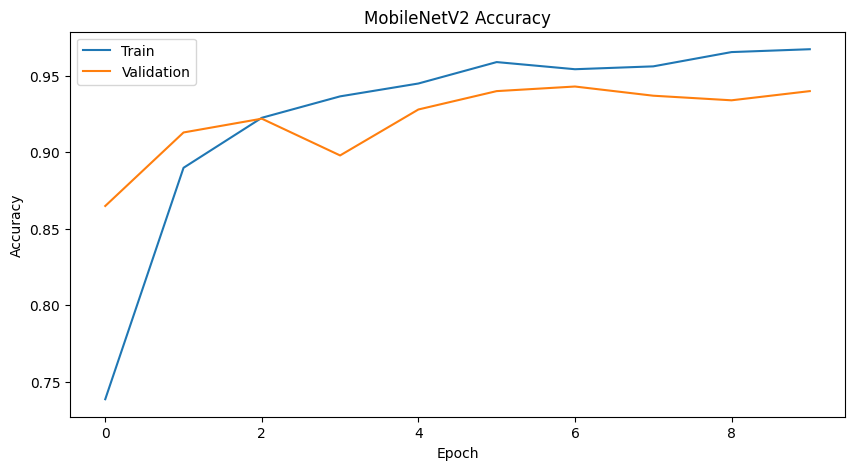

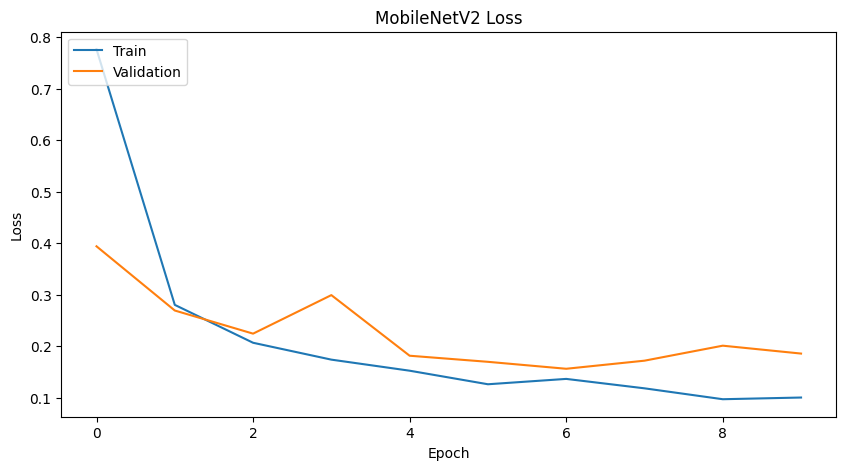

In [13]:
# Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('MobileNetV2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MobileNetV2 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()